In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

The project is aiming for building a classification model to predict 10 emotions{0-9} based on headline and summary of news articles.

There are 10 kinds emotions in the data, and emotions are not exclusive. To get the best performance, models were tunning on different parameters for each emotion type.  

Step 1: preprocessing data:
1. impute missing data
2. clean invalid values in the labeled emotions since the labels should be binary flags based on data description. 
3. some rare cases may also need to be taken care, such as some headline and summary are chinese and there are not utf-8 encoding.

Step 2: Correct the imbalanced datasets:
1. use resampling method to correct imbalance of the data sets. Imbalance is different among all emotion columns. So balancing procedure was performed on single emotion type level. 
2. didn't pickup the method of under sample majority class, because it may loose information dramatically.
3. used SMOTE method to oversample minority class. (has memory problem)
4. used randomly oversampling minority calss as the resampling method in the final model. 
5. also use cross validation method when evaluate performance during model training to avoid overfitting.

Step 3: Strategy to build the classification model to predict emotions:
1. feature selection:
    1) only use headline as feature: this was considered because logically, if a worker can gain emotion directly from headline, he may skip the summary info to finish labelling. This part is only for checking if the headline is good enough duing predicting emotion. 
    2) use headline and summary as feature: using two features together will gain more information.
2. remove stop words from text features
3. convert features to matrix of token counts
    use pipeline class (vectorizer and transformer with different parameters) to standardize the training data. 
4. Since multinomial bayes method is the baseline solution for text classification problem. I use multinomialNB and complementNB as classifiers. Other classification methods (e.g. RandomForest, logistic regression) were also tried. They were picked because the relative poor performance comparing with bayes method or memory problem. 
5. split data into two parts: 80% for training model and 20% for testing model. use cross validation method to evaluate performance. 
6. Since positive class '1' is the minority class and it is more important for emotion labeling. Precision and recall are better measurements. I used f1 score as the metrics to measure the performance of model.
7. Predict labels for each emotion type for new input data. 

In [2]:
rawdata = pd.read_json(r'homework.json', lines=True)
rawdata.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,headline,summary,worker_id
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,On Catalonia,Catalan lawmakers declared independence from S...,30266977
2,0.0,0.0,-2,0.0,0.0,0.0,0.0,0.0,0.0,1,A Spark of Romance Under Fluorescent Lighting,"Rose Burlingham, an art dealer and writer, mar...",54197764
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,Apple Removes Apps From China Store That Help ...,The world’s most valuable company appears to h...,41177265
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,Commerce Secretary’s Offshore Ties to Putin ‘C...,"Wilbur Ross, the commerce secretary, retained ...",56518865


In [3]:
rawdata.describe()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,headline,summary,worker_id
count,95570,95576,95606,95603,95569,95557,95561,95575,95567,95588,95760,95760,95568
unique,6,6,6,6,6,6,6,6,6,5,9266,9196,1306
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,Here’s what you need to know to start your day.,15266729
freq,85643,85818,87311,87695,85400,58192,91334,78226,73435,94832,228,814,317


In [4]:
# check the unique values for each emotion_X:

for i in range(10):
    emotion = 'emotion_'+str(i)
    print(emotion)
    print(rawdata[emotion].unique())
    print(rawdata[emotion].value_counts(normalize=True))
    print

emotion_0
['0.0' '1.0' 'cat' 'fnord' '-1' None '-2']
0.0      0.896128
1.0      0.095490
cat      0.002333
-1       0.002155
fnord    0.002051
-2       0.001842
Name: emotion_0, dtype: float64
emotion_1
['0.0' '1.0' 'cat' None 'fnord' '-1' '-2']
0.0      0.897903
1.0      0.093925
-1       0.002134
-2       0.002093
cat      0.001998
fnord    0.001946
Name: emotion_1, dtype: float64
emotion_2
['0.0' '-2' '1.0' 'cat' 'fnord' '-1' None]
0.0      0.913238
1.0      0.078572
-1       0.002228
fnord    0.002050
cat      0.001966
-2       0.001945
Name: emotion_2, dtype: float64
emotion_3
['0.0' '1.0' '-2' 'fnord' 'cat' '-1' None]
0.0      0.917283
1.0      0.074590
fnord    0.002197
-2       0.002061
-1       0.002019
cat      0.001851
Name: emotion_3, dtype: float64
emotion_4
['0.0' '1.0' 'fnord' '-1' 'cat' '-2' None]
0.0      0.893595
1.0      0.098390
-2       0.002103
cat      0.002051
fnord    0.001967
-1       0.001894
Name: emotion_4, dtype: float64
emotion_5
['1.0' '0.0' None '-1' 'f

In [5]:
# check missing data for each emotion_X:

rawdata.isnull().sum()

emotion_0    190
emotion_1    184
emotion_2    154
emotion_3    157
emotion_4    191
emotion_5    203
emotion_6    199
emotion_7    185
emotion_8    193
emotion_9    172
headline       0
summary        0
worker_id    192
dtype: int64

In [6]:
df = rawdata

In [7]:
# Impute missing values with majority of the emotion for each emotion column
df.fillna('0', inplace=True)

Based on the description of data set, the emotion columns are holding binary flags, however, I noticed there are
some values suh as fonrd, cat, -1, -2, etc. replaced with positive indicator '1'.

In [8]:
df = df.replace({'fnord': '1', 'cat': '1', '-1': '1', '-2': '1', '1.0':'1', '0.0': '0'})

# verify all bad values in emotion class are replaced. 
for i in range(10):
    emotion = 'emotion_' + str(i)
    print(emotion)
    print(df[emotion].value_counts())
    print()

emotion_0
0    85833
1     9927
Name: emotion_0, dtype: int64

emotion_1
0    86002
1     9758
Name: emotion_1, dtype: int64

emotion_2
0    87465
1     8295
Name: emotion_2, dtype: int64

emotion_3
0    87852
1     7908
Name: emotion_3, dtype: int64

emotion_4
0    85591
1    10169
Name: emotion_4, dtype: int64

emotion_5
0    58395
1    37365
Name: emotion_5, dtype: int64

emotion_6
0    91533
1     4227
Name: emotion_6, dtype: int64

emotion_7
0    78411
1    17349
Name: emotion_7, dtype: int64

emotion_8
0    73628
1    22132
Name: emotion_8, dtype: int64

emotion_9
1    95588
0      172
Name: emotion_9, dtype: int64



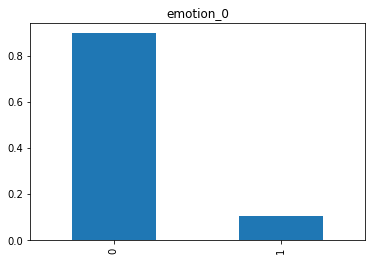

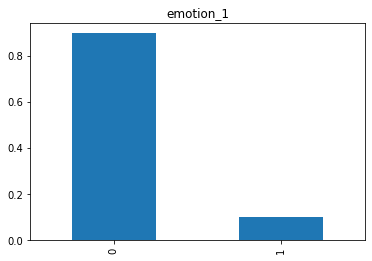

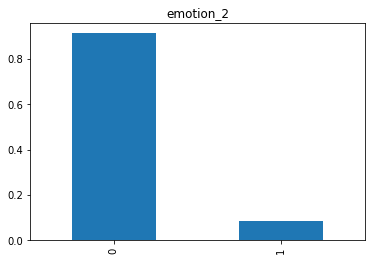

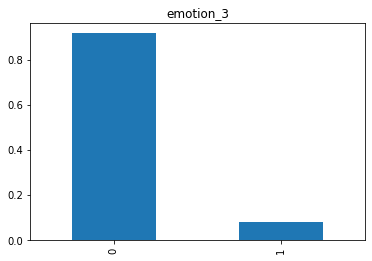

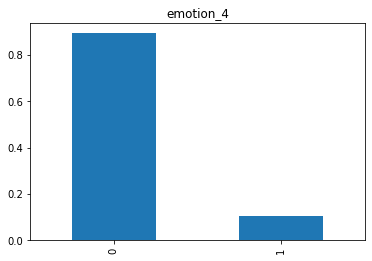

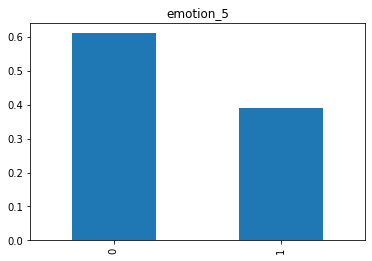

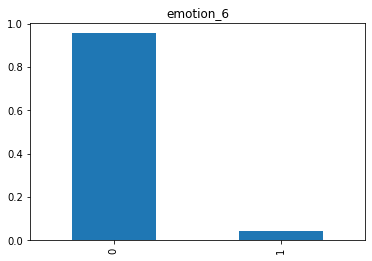

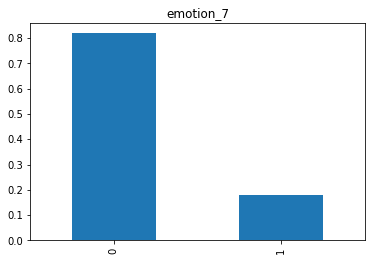

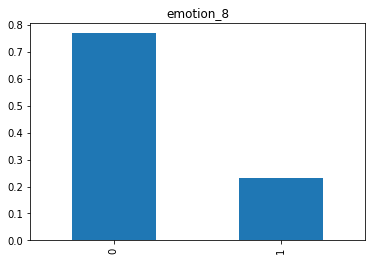

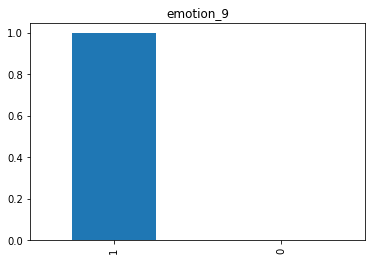

In [9]:
# check the balance of the processed data:
for i in range(10):
    emotion = 'emotion_'+str(i)
    
    df[emotion].value_counts(normalize=True).plot(kind='bar')
    plt.title(emotion)
    plt.show()
    print()
    

Above figures show the data are imbalanced in all emotions.

In [10]:
# functions to resample data
from imblearn.over_sampling import SMOTE

# functions to convert text into counts
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
# remove stop words in headline and summary: 
stop = stopwords.words('english')
df['headline_nosw'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['summary_nosw'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['headline_nosw_len'] = df['headline_nosw'].str.len()
df['summary_nosw_len'] = df['summary_nosw'].str.len()


In [12]:
# study independent variables headline and summary:

vectorizer = CountVectorizer()
encoder = LabelEncoder()

X = vectorizer.fit_transform(df['summary_nosw'])
print('headline features number: ', len(vectorizer.get_feature_names()))

X = vectorizer.fit_transform(df['summary_nosw']+df['headline_nosw'])
print('headline plus summary features number: ', len(vectorizer.get_feature_names()))

headline features number:  19392
headline plus summary features number:  23504


a good example of pipeline for text file:
https://github.com/sismetanin/sentiment-analysis-of-tweets-in-russian/blob/master/Sentiment%20Analysis%20of%20Tweets%20in%20Russian%20using%20Multinomial%20Naive%20Bayes.ipynb

In [13]:


res_hl = {}

for i in range(10):
    emotion = 'emotion_'+str(i)
    
    X = vectorizer.fit_transform(df['headline_nosw'])
    y = encoder.fit_transform(df[emotion])
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # resample data set to increase minority calss
    smote = SMOTE()
    X_new, y_new = smote.fit_sample(X_train, y_train)

    
    clf_pipe = Pipeline([('tfidf', TfidfTransformer()),
                         ('mnb', MultinomialNB())])

    tuned_parameters = {
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'mnb__alpha': [1, 0.1, 0.01]
    }

    np.errstate(divide='ignore')
    clf = GridSearchCV(clf_pipe, tuned_parameters, cv=10, scoring='f1_macro')
    clf.fit(X_new, y_new)
    
    print(emotion)
    print()
    res_hl[emotion] = clf.best_score_
    print('Best score with best parameters set:')
    print('%0.4f with parameters %r' % (clf.best_score_, clf.best_params_))
    
    print('Detailed grid scores for each training model:')
    print()
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                                 clf.cv_results_['std_test_score'], 
                                 clf.cv_results_['params']):
        print('%0.4f +/-%0.04f with parameters %r' % (mean, std * 2, params))
    print()
    
print(res_hl)

emotion_0

Best score with best parameters set:
0.6618 with parameters {'mnb__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Detailed grid scores for each training model:

0.6432 +/-0.3317 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.6357 +/-0.3352 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.6478 +/-0.3310 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.6392 +/-0.3311 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.6587 +/-0.3317 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.6523 +/-0.3322 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.6589 +/-0.3316 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.6517 +/-0.3314 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.6618 +/-0.3317 with parameters {'m

emotion_7

Best score with best parameters set:
0.7034 with parameters {'mnb__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Detailed grid scores for each training model:

0.6935 +/-0.0474 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.6862 +/-0.0488 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.6975 +/-0.0446 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.6910 +/-0.0462 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.7020 +/-0.0442 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.6975 +/-0.0439 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.7015 +/-0.0437 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.6967 +/-0.0438 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.7034 +/-0.0432 with parameters {'m

In [14]:
res_hl_sm = {}

for i in range(10):
    emotion = 'emotion_'+str(i)
    
    X = vectorizer.fit_transform(df['headline_nosw'] + ' ' + df['summary_nosw'])
    y = encoder.fit_transform(df[emotion])
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # resample data set to increase minority calss
    smote = SMOTE()
    X_new, y_new = smote.fit_sample(X_train, y_train)

    
    clf_pipe = Pipeline([('tfidf', TfidfTransformer()),
                         ('mnb', MultinomialNB())])

    tuned_parameters = {
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'mnb__alpha': [1, 0.1, 0.01]
    }

    np.errstate(divide='ignore')
    clf = GridSearchCV(clf_pipe, tuned_parameters, cv=10, scoring='f1_macro')
    clf.fit(X_new, y_new)
    
    print(emotion)
    print()
    res_hl_sm[emotion] = clf.best_score_
    print('Best score with best parameters set:')
    print('%0.4f with parameters %r' % (clf.best_score_, clf.best_params_))
    
    print('Detailed grid scores for each training model:')
    print()
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                                 clf.cv_results_['std_test_score'], 
                                 clf.cv_results_['params']):
        print('%0.4f +/-%0.04f with parameters %r' % (mean, std * 2, params))
    print()
    
print(res_hl_sm)

emotion_0

Best score with best parameters set:
0.7419 with parameters {'mnb__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Detailed grid scores for each training model:

0.7232 +/-0.1548 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.7043 +/-0.1532 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.7191 +/-0.1224 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.7049 +/-0.1210 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.7388 +/-0.1646 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.7255 +/-0.1632 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.7328 +/-0.1256 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.7205 +/-0.1248 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.7419 +/-0.1659 with parameters {'m

emotion_7

Best score with best parameters set:
0.8000 with parameters {'mnb__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Detailed grid scores for each training model:

0.7834 +/-0.0509 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.7679 +/-0.0449 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.7835 +/-0.0423 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.7733 +/-0.0384 with parameters {'mnb__alpha': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.7978 +/-0.0597 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.7873 +/-0.0541 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.7897 +/-0.0458 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.7815 +/-0.0430 with parameters {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
0.8000 +/-0.0629 with parameters {'m

In [15]:
df_hl = pd.DataFrame.from_dict(res_hl, orient='index', columns=['f1_headline'])
df_hl_sm = pd.DataFrame.from_dict(res_hl_sm, orient='index', columns=['f1_headline_summary'])
df_res = df_hl.join(df_hl_sm)
df_res

,f1_headline,f1_headline_summary
emotion_0,0.661831,0.741924
emotion_1,0.733466,0.834730
emotion_2,0.706645,0.692817
emotion_3,0.672982,0.782621
emotion_4,0.665256,0.746437
emotion_5,0.605413,0.621157
emotion_6,0.564107,0.795584
emotion_7,0.703380,0.799967
emotion_8,0.592921,0.685290
emotion_9,0.739083,0.949029


Text(0, 0.5, 'f1 score')

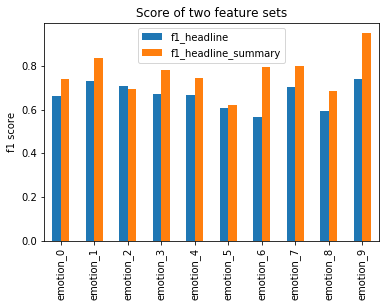

In [16]:
# plot to compare the performance of two feature sets:

df_res.plot(kind='bar')
plt.title('Score of two feature sets')
plt.ylabel('f1 score')

Conclusion: 
1. The best performance for each emotion type are shown in above figures. There are still a lot of space to improve the model.

2. When preparing the data, I converted each emotion class only including '1' or '0', but other 'bad' values such as 'fonrd', 'cat', '-1', '-2' should be correctly addressed by the context. Since the data only gives the general emotion_{0-9}, it is hard to guess what these bad values actually mean. Multi-class for each emotion type may also be used if they have special meaning.   
3. There are still many ways to improve the model, such as extra feature engineering, methods for dealing with imbalance dataset, tokenization, hyperparameter tunning on different classifiers with better performance of computer.    